In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from createData import createDataFrame


## Initialize Random Data Frame
# this data frame consists of data generated from a random "Quality" score between 0-1
# Intensity and Negative control concentration is generated from this quality score
toAnalyze = createDataFrame(1000001)

toAnalyze

,Trials,Quality,Negative_Control_Concentration,Intensity,Condition
0,1.0,0.040540,62.9825,26.93,1
1,2.0,0.736035,8.59492,64.0475,1
2,3.0,0.353428,40.669,34.8887,2
3,4.0,0.053727,63.5243,8.70987,3
4,5.0,0.696184,14.2989,64.4108,1
...,...,...,...,...,...
999996,999997.0,0.202389,45.4154,4.10628,3
999997,999998.0,0.395483,48.8473,71.2269,2
999998,999999.0,0.704270,16.5653,67.1945,1
999999,1000000.0,0.289896,59.7341,69.4635,3


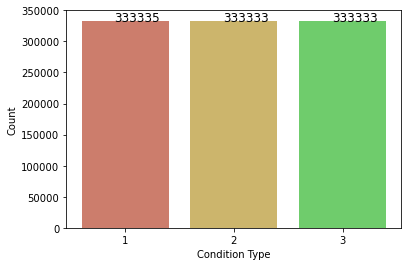

In [58]:
##Display counts of each condition type, describing the replicate setups

toAnalyze["Condition"].astype(str)
condition_types, condition_counts = np.unique(toAnalyze["Condition"], return_counts = True)
plt.bar(condition_types, condition_counts, color = ['#CC7D6C', '#CCB56C', '#6FCC6C'])
plt.xticks([1,2,3])
plt.text(0.9, condition_counts[0] + 10, condition_counts[0], fontsize = "large")
plt.text(1.9, condition_counts[1] + 10, condition_counts[1], fontsize = "large")
plt.text(2.9, condition_counts[2] + 10, condition_counts[2], fontsize = "large")
plt.xlabel("Condition Type")
plt.ylabel("Count")
plt.show()

In [59]:
##Initialize data for boxplots and barplot below

NTCboxData = []
IntboxData = []
negCount = []

for condition in [1,2,3]:
    NTCboxDatai = toAnalyze.loc[np.where(toAnalyze["Condition"] == condition), "Negative_Control_Concentration"]
    IntboxDatai = toAnalyze.loc[np.where(toAnalyze["Condition"] == condition), "Intensity"]
    negCounti = np.count_nonzero(toAnalyze.loc[np.where((toAnalyze["Condition"] == condition) &
                                                       (toAnalyze["Negative_Control_Concentration"] > 20)),"Negative_Control_Concentration"])
    
    NTCboxData.append(NTCboxDatai)
    IntboxData.append(IntboxDatai)
    negCount.append(negCounti)

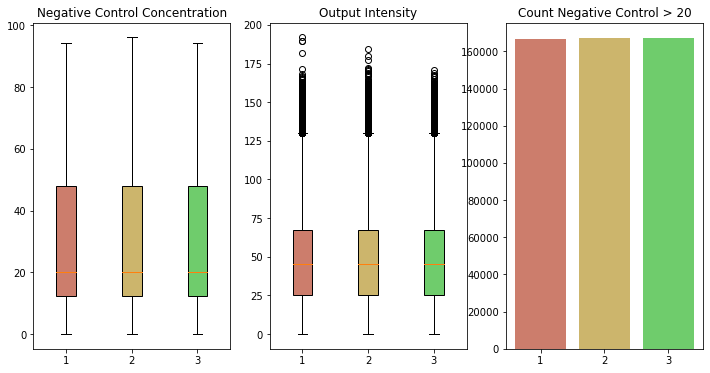

In [60]:
colors = ['#CC7D6C', '#CCB56C', '#6FCC6C']
fig, (ntc_ax, intensity_ax, countNTC_ax) = plt.subplots(1, 3, figsize = (12,6))

ntc_box = ntc_ax.boxplot(NTCboxData, patch_artist=True)
ntc_ax.set_title("Negative Control Concentration")

intBox = intensity_ax.boxplot(IntboxData, patch_artist=True)
intensity_ax.set_title("Output Intensity")

ntcCount = countNTC_ax.bar([1,2,3], negCount, color = ['#CC7D6C', '#CCB56C', '#6FCC6C'])
countNTC_ax.set_title("Count Negative Control > 20")

for plot in [ntc_box, intBox]:
    i = 0
    for patch in plot['boxes']:
        patch.set_facecolor(colors[i])
        i += 1


plt.show()

In [55]:
good_intensity = []
good_NTC = []

for condition in [0,1,2]:
    good_intensityi = IntboxData[condition].iloc[np.where(NTCboxData[condition] <= 20)]
    good_NTCi = NTCboxData[condition].iloc[np.where(NTCboxData[condition] <= 20)]
    
    good_NTC.append(good_NTCi)
    good_intensity.append(good_intensityi)

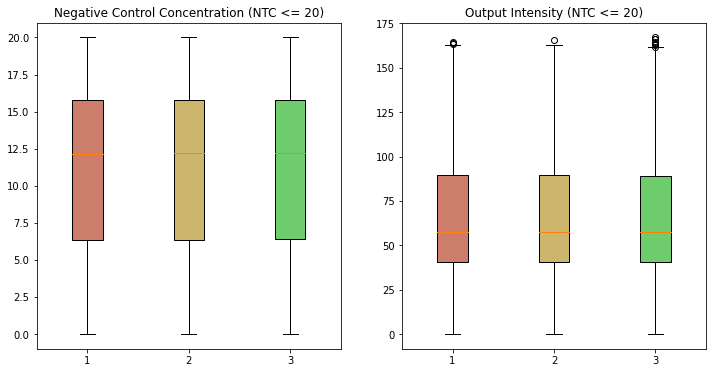

In [56]:
colors = ['#CC7D6C', '#CCB56C', '#6FCC6C']
fig, (ntc_ax, intensity_ax) = plt.subplots(1, 2, figsize = (12,6))

ntc_box = ntc_ax.boxplot(good_NTC, patch_artist=True)
ntc_ax.set_title("Negative Control Concentration (NTC <= 20)")

intBox = intensity_ax.boxplot(good_intensity, patch_artist=True)
intensity_ax.set_title("Output Intensity (NTC <= 20)")

for plot in [ntc_box, intBox]:
    i = 0
    for patch in plot['boxes']:
        patch.set_facecolor(colors[i])
        i += 1


plt.show()

(3, 33366)